# PDF RAPTOR Demo

This notebook demonstrates how to:
1. Extract content from PDFs (text, tables, images)
2. Apply RAPTOR clustering for hierarchical summarization
3. Store embeddings in FAISS vector store
4. Query the vector store

**Choose your LLM provider**: OpenAI or Google Gemini

## Setup

**Prerequisites:**
1. Run `uv sync` in project root
2. Copy `.env.example` to `.env` and configure API keys
3. Place PDF file in `data/` directory

In [1]:
import sys
import os

# Add parent directory to path to import src modules
sys.path.insert(0, os.path.abspath('..'))

# Remove cached modules to force fresh import
modules_to_remove = [key for key in sys.modules.keys() if key.startswith('src.')]
for module in modules_to_remove:
    del sys.modules[module]

# Import modules
from src.config import Config
from src.pdf_processor import PDFProcessor
from src.raptor import RAPTORProcessor
from src.vector_store import FAISSVectorStore

print("Modules loaded successfully")

/home/parshav-potato/projects/western_digital_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modules loaded successfully


## Configuration

**LLM Provider**: Choose `"openai"` or `"gemini"`

**Embeddings Options:**
- `USE_LOCAL_EMBEDDINGS = True`: sentence-transformers (free, offline, runs locally)
  - No API costs or rate limits
  - Works offline
  - First run downloads model (~90MB)
  - Model: all-MiniLM-L6-v2 (384 dimensions)
  
- `USE_LOCAL_EMBEDDINGS = False`: API embeddings (OpenAI or Gemini)
  - Costs money and has rate limits
  - Higher quality (1536 dimensions for OpenAI)

In [2]:
# CHOOSE YOUR PROVIDER HERE
LLM_PROVIDER = "gemini"  # Switched to Gemini due to quota limits

# USE LOCAL EMBEDDINGS (no API calls, runs on your computer)
USE_LOCAL_EMBEDDINGS = True

# Initialize configuration
config = Config(llm_provider=LLM_PROVIDER, use_local_embeddings=USE_LOCAL_EMBEDDINGS)
print(f"Configuration loaded: {config}")
print(f"Embeddings: {'Local (sentence-transformers)' if USE_LOCAL_EMBEDDINGS else f'{LLM_PROVIDER} API'}")

Configuration loaded: Config(provider=gemini, model=gemini-2.0-flash)
Embeddings: Local (sentence-transformers)


## Set File Paths

In [3]:
# Set your PDF file path
PDF_FILE = "../data/1706.03762v7.pdf"  # Modify as needed

# Output directories
IMAGE_OUTPUT_DIR = "../data/images"
VECTOR_STORE_DIR = "../data/vector_store"

# Create directories if they don't exist
os.makedirs(IMAGE_OUTPUT_DIR, exist_ok=True)
os.makedirs(VECTOR_STORE_DIR, exist_ok=True)

print(f"PDF file: {PDF_FILE}")
print(f"Images directory: {IMAGE_OUTPUT_DIR}")
print(f"Vector store directory: {VECTOR_STORE_DIR}")

PDF file: ../data/1706.03762v7.pdf
Images directory: ../data/images
Vector store directory: ../data/vector_store


## Step 1: Extract Content from PDF

Process:
- Extract text chunks and tables
- Extract and analyze images
- Generate summaries using chosen LLM

### Automatic Batch Processing

The processor automatically:
- Processes in batches (10 elements at a time)
- Shows progress for each batch
- Prevents crashes with automatic delays
- Handles errors gracefully
- Estimates time and cost before starting

In [4]:
# Initialize PDF processor
pdf_processor = PDFProcessor(config)

# Process the PDF - it will automatically handle batching to prevent crashes!
# The processor shows you what it will do before starting
documents, raw_texts = pdf_processor.process_pdf(
    pdf_path=PDF_FILE,
    output_image_dir=IMAGE_OUTPUT_DIR,
    # Optional parameters (all have smart defaults):
    # max_elements=100,  # Limit elements to process (None = all)
    # skip_images=True,  # Skip images to save time (False = process images)
    # batch_size=10      # Elements per batch (10 is default)
)

print(f"\nSummary:")
print(f"  Total documents: {len(documents)}")
print(f"  Total raw texts: {len(raw_texts)}")

Extracting elements from PDF: ../data/1706.03762v7.pdf


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Extracted 27 elements

Processing Plan:
  Total elements found: 27
  Will process: 27
  Batch size: 10
  Estimated batches: 3
  Skip images: False

📝 Processing text and tables in batches...
  📦 Batch 1: Processing elements 1-10 of 27
  📦 Batch 2: Processing elements 11-20 of 27
  📦 Batch 3: Processing elements 21-27 of 27
Processed 27 text/table elements

Processing images in batches...
  Found 7 images to process
  Batch 1: Processing images 1-7 of 7
Processed 7 images

Total: 34 documents extracted

Summary:
  Total documents: 34
  Total raw texts: 34


### Inspect Extracted Documents

In [5]:
# Show first few documents
print("\nSample documents:\n")
for i, doc in enumerate(documents[:3]):
    print(f"Document {i+1}:")
    print(f"  Type: {doc.metadata.get('type', 'unknown')}")
    print(f"  Content preview: {doc.page_content[:200]}...")
    print()


Sample documents:

Document 1:
  Type: text
  Content preview: The paper "Attention Is All You Need" introduces the Transformer, a novel neural network architecture based solely on attention mechanisms, dispensing with recurrence and convolutions. The Transformer...

Document 2:
  Type: text
  Content preview: This text acknowledges the equal contributions of several individuals to a research effort, culminating in a publication at NIPS 2017. Jakob initiated the idea of using self-attention instead of RNNs....

Document 3:
  Type: text
  Content preview: This paper introduces the Transformer, a novel neural network architecture for sequence modeling and transduction that moves away from recurrent networks (RNNs) like LSTMs and GRUs. RNNs, while state-...



## Step 2: Apply RAPTOR Clustering

RAPTOR creates hierarchical tree structure:
- **Level 0 (Leaf)**: Original extracted texts
- **Level 1**: Summaries of clustered leaf texts
- **Level 2**: Summaries of Level 1 clusters
- **Level 3**: Summaries of Level 2 clusters

Enables retrieval at different abstraction levels.

In [6]:
!uv add sentence-transformers

Resolved 259 packages in 4ms
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
   Building pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
      Built pdf-raptor-demo @ file:///home/parshav-potato/projects/western_digital_p
Prepared 1 package in 1.68s                                              
Uninstalled 1 package in 0.95ms
Installed 1 pac

In [7]:
# Initialize RAPTOR processor
raptor = RAPTORProcessor(config)

# Apply RAPTOR clustering (3 levels of hierarchy)
all_texts = raptor.process(texts=raw_texts, n_levels=3)

print(f"\nRAPTOR Results:")
print(f"  Original texts: {len(raw_texts)}")
print(f"  Total texts (with summaries): {len(all_texts)}")
print(f"  New summaries created: {len(all_texts) - len(raw_texts)}")

🔧 Using local embeddings (sentence-transformers/all-MiniLM-L6-v2)


/home/parshav-potato/projects/western_digital_project/demo_code/src/config.py:58: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  return HuggingFaceEmbeddings(



Building RAPTOR tree with 3 levels...
Starting with 34 leaf texts


/home/parshav-potato/projects/western_digital_project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Level 1: Generated 6 clusters
  Level 2: Generated 1 clusters
  Level 1: Added 6 summaries
  Level 2: Added 1 summaries
RAPTOR processing complete: 41 total texts

RAPTOR Results:
  Original texts: 34
  Total texts (with summaries): 41
  New summaries created: 7


## Step 3: Create FAISS Vector Store

Store all texts (original + summaries) in FAISS vector database for fast similarity search.

In [8]:
# Initialize vector store
vector_store = FAISSVectorStore(config)

# Create vector store from all texts
vector_store.create_from_texts(all_texts)

# Display stats
stats = vector_store.get_stats()
print(f"\nVector Store Stats:")
for key, value in stats.items():
    print(f"  {key}: {value}")

🔧 Using local embeddings (sentence-transformers/all-MiniLM-L6-v2)

Creating FAISS vector store from 41 texts...
Vector store created successfully

Vector Store Stats:
  status: initialized
  n_vectors: 41
  embedding_provider: gemini


### Save Vector Store

In [9]:
# Save vector store for later use
vector_store.save(VECTOR_STORE_DIR)
print(f"Vector store saved to {VECTOR_STORE_DIR}")


Saving vector store to ../data/vector_store...
Vector store saved successfully
Vector store saved to ../data/vector_store


## Step 4: Query the Vector Store

Perform semantic search on documents:

In [10]:
# Example query
query = "What are the main topics discussed in the document?"  # Modify as needed

print(f"Query: {query}\n")

# Search for similar documents
results = vector_store.similarity_search_with_score(query, k=5)

print(f"\nTop {len(results)} Results:\n")
for i, (doc, score) in enumerate(results, 1):
    print(f"Result {i} (Score: {score:.4f}):")
    print(f"{doc.page_content[:300]}...")
    print()

Query: What are the main topics discussed in the document?


Top 5 Results:

Result 1 (Score: 1.4476):
Here's a description of the text and information shown in the image:

The image displays a series of words and phrases, arranged in columns. The words are: "The", "Law", "will", "never", "be", "perfect", "but", "its", "application", "should", "be", "just", "this", "is", "what", "we", "are", "missing...

Result 2 (Score: 1.4689):
Here is a description of the text and information shown in the image:

The image is a diagram of a neural network architecture, specifically a transformer model. It shows the flow of data through the different layers and components of the model.

Here's a breakdown of the key elements:

*   **Inputs...

Result 3 (Score: 1.4724):
Here is the information extracted from the image:

The image contains the following text: "It is in this spirit that a majority of American governments have passed new laws since 2009 making the registration or voting process more diff

### Try Custom Queries

In [11]:
# Interactive query cell
your_query = "Enter your question here"

results = vector_store.similarity_search(your_query, k=3)

print(f"\nQuery: {your_query}\n")
for i, doc in enumerate(results, 1):
    print(f"\nResult {i}:")
    print(doc.page_content)
    print("-" * 80)


Query: Enter your question here


Result 1:
[11] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for im- age recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 770–778, 2016.

[12] Sepp Hochreiter, Yoshua Bengio, Paolo Frasconi, and Jürgen Schmidhuber. Gradient flow in recurrent nets: the difficulty of learning long-term dependencies, 2001.

[13] Sepp Hochreiter and Jürgen Schmidhuber. Long short-term memory. Neural computation, 9(8):1735–1780, 1997.

[14] Zhongqiang Huang and Mary Harper. Self-training PCFG grammars with latent annotations across languages. In Proceedings of the 2009 Conference on Empirical Methods in Natural Language Processing, pages 832–841. ACL, August 2009.

[15] Rafal Jozefowicz, Oriol Vinyals, Mike Schuster, Noam Shazeer, and Yonghui Wu. Exploring the limits of language modeling. arXiv preprint arXiv:1602.02410, 2016.

[16] Łukasz Kaiser and Samy Bengio. Can active memory replace a

## Step 5: Load Existing Vector Store (Optional)

Load previously saved vector store to skip processing:

In [12]:
# Load previously saved vector store
# vector_store_loaded = FAISSVectorStore(config)
# vector_store_loaded.load(VECTOR_STORE_DIR)

# print("Vector store loaded successfully")
# print(f"Stats: {vector_store_loaded.get_stats()}")

## Bonus: Analyze Token Distribution

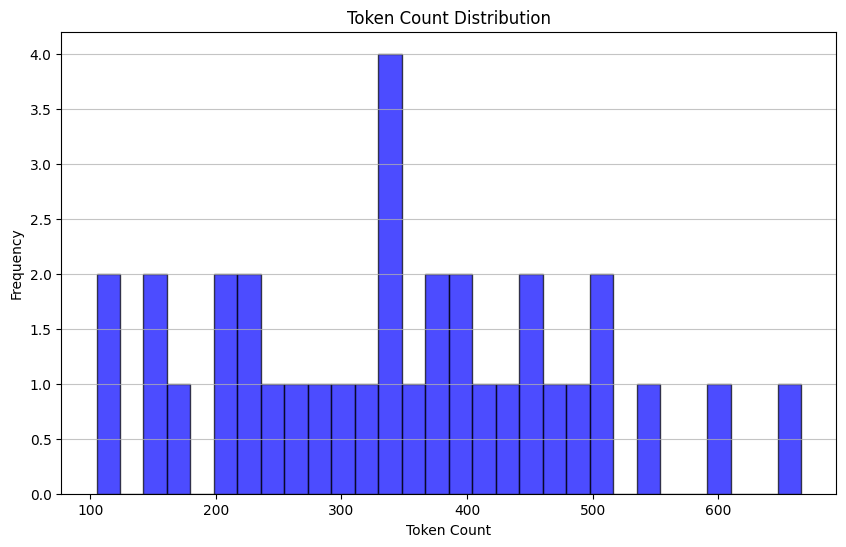


Token Statistics:
  Mean: 347.8
  Max: 666
  Min: 105
  Total: 11,826


In [13]:
import tiktoken
import matplotlib.pyplot as plt

def count_tokens(text: str, encoding_name: str = "cl100k_base") -> int:
    """Count tokens in text."""
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(text))

# Count tokens for each document
token_counts = [count_tokens(text) for text in raw_texts]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

print(f"\nToken Statistics:")
print(f"  Mean: {sum(token_counts)/len(token_counts):.1f}")
print(f"  Max: {max(token_counts)}")
print(f"  Min: {min(token_counts)}")
print(f"  Total: {sum(token_counts):,}")

## Summary

Successfully completed:
- Extracted content from PDF
- Applied RAPTOR hierarchical clustering
- Created FAISS vector store
- Performed semantic search queries

### Next Steps:
1. Try different PDFs
2. Experiment with different query strategies
3. Switch between OpenAI and Gemini
4. Adjust number of RAPTOR levels
5. Integrate into RAG pipeline